In [245]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import namedtuple, deque
import random
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import control
from ExtendedKF import *
import time
import pylab as pl
from IPython import display
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deviceCPU = torch.device("cpu")
torch.set_default_dtype(torch.float64)
print('The device that will be used is:', device, 'also', deviceCPU)

The device that will be used is: cpu also cpu


In [246]:
# Here we create the neural network representing the DQN actor.

class DeepQNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):#, seed):
        super().__init__()
        self.OneLayer = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, output_dim)
        )
        #self.seed = torch.manual_seed(seed)

    def forward(self, x):
        return self.OneLayer(x)

In [247]:
# Here we create the replay buffer that will be used for mini-batch learning.
Transitions = namedtuple('Transitions', ('state', 'action', 'reward', 'next_state'))

class ReplayBuffer(deque):
    def __init__(self, capacity):
        super().__init__([], maxlen=capacity)

    def sample(self, batch_size, device):
        transitions_deque =  random.sample(self, batch_size)
        batch = Transitions(*zip(*transitions_deque))
        states = torch.cat(batch.state).to(device)
        actions = torch.cat(batch.action).to(device)
        rewards = torch.cat(batch.reward).to(device)
        next_state = torch.cat(batch.next_state).to(device)
        return states, actions, rewards, next_state
    
    def push(self, *args):
        self.append(Transitions(*args))

In [248]:
# Here we define the DQN agent: where all the learning happens

class DQN_Agent(object):
    def __init__(self, state_dim, number_of_actions, hidden_size, gamma, device, tau, capacity, lr):
        self.actorNet = DeepQNetwork(state_dim, number_of_actions, hidden_size).to(device)
        self.actorNet_target = DeepQNetwork(state_dim, number_of_actions, hidden_size).to(device)
        self.actorNet.eval()
        self.actorNet_target.eval()
        self.optimizer = torch.optim.Adam(self.actorNet.parameters(), lr=lr)
        self.Memory = ReplayBuffer(capacity)
        self.gamma = gamma
        self.tau = tau
        self.learning_rate = lr
        self.device = device
        for target_param, param in zip(self.actorNet_target.parameters(), self.actorNet.parameters()):
            target_param.data.copy_(param.data)
    def get_action_index(self, state, epsilon):
        self.actorNet.eval()
        if (random.random() > epsilon):
            action = self.actorNet.forward(state).argmax()
        else:
            A = self.actorNet.forward(state)
            i = random.sample(range(len(A.T)), k=1)
            action = torch.tensor(i)
        return torch.atleast_2d(action)
    
    def update_network(self, batch_size):
        self.optimizer.zero_grad()
        self.actorNet.train()
        self.actorNet_target.eval()
        states, actions, rewards, next_states = self.Memory.sample(batch_size, self.device)
        
        Qnow = self.actorNet(states).gather(1, actions)
        Qplus = torch.atleast_2d(self.actorNet_target(next_states).detach().max(1)[0]).T
        loss = F.mse_loss(Qnow, rewards + self.gamma * Qplus)
        loss.backward()
        self.optimizer.step()
        for target_param, param in zip(self.actorNet_target.parameters(), self.actorNet.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))




In [249]:
a = torch.randn(4, 4)
print(a)
print(a.max(1)[0])

tensor([[-0.0964, -0.3732,  2.4022, -1.1170],
        [-0.7749,  0.0570,  1.1258,  1.0130],
        [-0.7538,  0.0290, -1.2763, -0.6170],
        [-0.5088, -0.5474, -0.4374, -1.5955]])
tensor([ 2.4022,  1.1258,  0.0290, -0.4374])


In [250]:
a = torch.randn(4, 4)
a
print(torch.argmax(a, dim=0))
print(torch.argmax(a))

tensor([0, 1, 3, 3])
tensor(15)


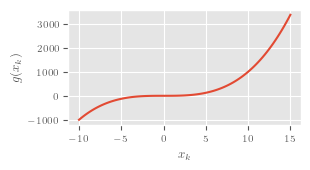

In [251]:
# Model parameters, state dynamics, measurement dynamics, and gradients:
# Noise parameters
saveFigs = True
FigDim1 = 3.0
FigDim2 = 1.5
Model_Select = 1
a = torch.tensor([[1.00]])
Klqr, _, _ = control.dlqr(1, 1, 1, 1)
# Maps and gradients
def stateDynamics(x,u):
    fxu = {
        1: a * x + u,
        2: a * x + u,
        3: a * x + u
    }
    return torch.atleast_2d(fxu.get(Model_Select))

def stateDynamics_prime(x,u):
    fprime = {
        1: a,
        2: a,
        3: a
    }
    return torch.atleast_2d(fprime.get(Model_Select))

def measurementDynamics(x):
    gx = {
        1: x ** 3,
        2: 2 * torch.tanh(0.5 * (x-5)),
        3: x
    }
    return torch.atleast_2d(gx.get(Model_Select))

def measurementDynamics_prime(x):
    gprime = {
        1: 3 * x ** 2,
        2: (1- torch.tanh( 0.5 * (x-5)) ** 2) * 0.5 * 2,
        3: 1.0 + 0.000*x
    }
    return torch.atleast_2d(gprime.get(Model_Select))

t = torch.linspace(-10,15,100)
gx = measurementDynamics(t)
fig= plt.figure(figsize=(FigDim1,FigDim2))
plt.style.use('ggplot')
plt.rc('xtick', labelsize=7) #fontsize of the x tick labels
plt.rc('ytick', labelsize=7) #fontsize of the y tick labels
plt.xlabel('$x_k$', fontsize=9)  
plt.ylabel('$g(x_k)$', fontsize=9) 
plt.rc('text', usetex=True)
plt.plot(t.detach().numpy(), gx.detach().numpy().reshape((100,1)))
#plt.savefig('Figures/outputDynamics.pdf',bbox_inches ="tight")

In [252]:
Q = torch.tensor([[2.0]])
R = torch.tensor([[2.0]])
# Define model: dynamics, dynamics gradients, and noise covariances.
model = Model(stateDynamics, measurementDynamics, stateDynamics_prime, measurementDynamics_prime, Q, R)
# Define information state: (mean, covariance), from an extended Kalman Fitler.
x0=torch.tensor([[0.1]])
P0=torch.tensor([[2.6]])
Hyperstate = Extended_KF(x0, P0, model)

KeyboardInterrupt: 

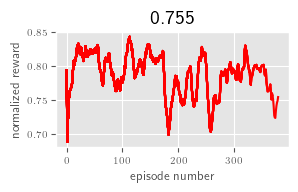

In [253]:
hidden_size = 128
lr = 1e-6# * 10
Horizon_Length = 16
RollOuts = 16*2
batch_size = 32*2#Horizon_Length# * RollOuts
gamma = 0.95
Max_reward = 500
rx = 2
num_of_u = 500
actions_set = 10 * (np.random.rand(1,num_of_u) - 0.5)
EffectiveHorizonLength = (1 - gamma ** Horizon_Length) / (1 - gamma)
agent = DQN_Agent(state_dim=rx, number_of_actions=num_of_u, hidden_size=hidden_size, gamma=gamma, device=device, tau=0.01, capacity=batch_size*16, lr=lr)
rewards = []
avg_rewards = []
EpisodesNumber = 500
epsilon = 0.2
fig= plt.figure(figsize=(FigDim1,FigDim2))
pl.style.use('ggplot')
pl.rc('xtick', labelsize=7) #fontsize of the x tick labels
pl.rc('ytick', labelsize=7) #fontsize of the y tick labels
pl.xlabel('episode number', fontsize=9)  
pl.ylabel('normalized reward', fontsize=9) 
pl.rc('text', usetex=True)

for episode in range(EpisodesNumber):
    episode_reward = 0
    ExplorationGamma = (EpisodesNumber - episode) / EpisodesNumber
    if (episode%200==0 & episode>1):
        print()
        #agent.critic_learning_rate = agent.critic_learning_rate * 1/2
        #agent.actor_learning_rate = agent.actor_learning_rate * 1/2
    for jj in range(RollOuts):
        Hyperstate.ChangeInitialStates(torch.atleast_2d(20*(torch.rand(1, 1)-0.5)), torch.atleast_2d(20 * torch.rand(1, 1)))
        for step in range(Horizon_Length):
            state = torch.cat((Hyperstate.Mean.T, Hyperstate.Covariance.T), dim=1).to(device)
            action_index = agent.get_action_index(state, epsilon).to(deviceCPU)
            action = actions_set[0, action_index.detach()]
            action = torch.atleast_2d(action + 0*ExplorationGamma * 2.0*torch.randn(1, 1)).detach()
            true_state = torch.sqrt(Hyperstate.Covariance) * torch.randn(1, 1) + Hyperstate.Mean #we might need next t-step
            true_state_Plus = stateDynamics(true_state, action) + torch.sqrt(Q) * torch.randn(1, 1)
            measurement_Plus_realization = measurementDynamics(true_state_Plus) + torch.sqrt(R) * torch.randn(1, 1)
            reward = - ((Hyperstate.Mean) ** 2 + Hyperstate.Covariance + action ** 2) ###########################
            if reward < -Max_reward:
                reward = torch.tensor([[-Max_reward]])
            
            Hyperstate.ApplyEKF(action, measurement_Plus_realization)
            new_state = torch.cat((Hyperstate.Mean.T, Hyperstate.Covariance.T), dim=1)

            reward = reward.detach() / Max_reward 
            agent.Memory.push(state, action_index, reward, new_state)
            state = new_state
            episode_reward += reward * gamma ** step
    if len(agent.Memory) >= batch_size:
        for jjj in  range(8):
            agent.update_network(batch_size)

    rewards.append(episode_reward.numpy() / (EffectiveHorizonLength * RollOuts) + 1)
    avg_rewards.append(np.mean(rewards[-10:]))
    if episode%10==0:
        pl.plot(avg_rewards, 'r')
        pl.title(round(avg_rewards[-1], 3))
        display.clear_output(wait=True)
        display.display(pl.gcf())
        time.sleep(0.001)

In [ ]:
aa = torch.tensor([[1, 2]])

print(torch.cat((aa,aa), dim=1))
print(np.random.rand(1,10))

tensor([[1, 2, 1, 2]])
[[0.14332219 0.66871022 0.92272566 0.17487124 0.39337098 0.25016459
  0.27956695 0.54229418 0.81276702 0.10209268]]


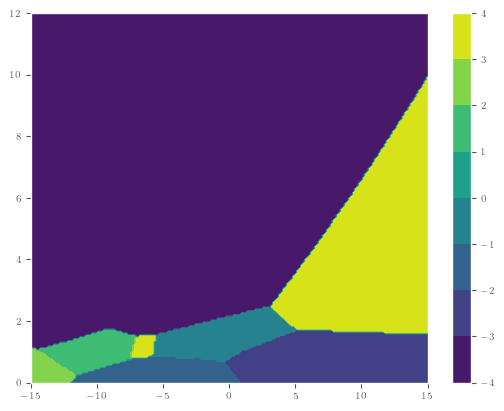

In [ ]:
K = agent.get_action_index#get_action
t = torch.atleast_2d(torch.linspace(-7, 7, 100))

plt.figure()
N=200
x=torch.linspace(-15,15,N)
y=torch.linspace(0,12,N)
xx, yy = torch.meshgrid(x,y)
uu = xx -0.1

for i in range(N):
    for j in range(N):
        state = torch.tensor((xx[i, j], yy[i, j])).T
        state = torch.atleast_2d(state)
        uu[i, j] = actions_set[0,K(state, 0).detach()]

plt.contourf(xx.detach().numpy(), yy.detach().numpy(), uu.detach().numpy())
plt.colorbar()


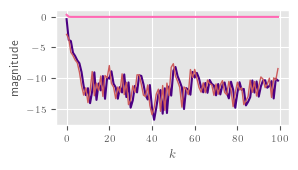

In [ ]:
T = 100
x = np.ones(T)
P = np.ones(T)
u = np.ones(T)
x_true=np.ones(T)

StateReq = deque([])
ActionReq = deque([])


Hyperstate.ChangeInitialStates(torch.atleast_2d(torch.randn(1, 1)), torch.atleast_2d(torch.rand(1, 1)))
true_state = torch.sqrt(Hyperstate.Covariance) * torch.randn(1, 1) + Hyperstate.Mean #we might need next t-step

for k in range(T):
    state = torch.cat((Hyperstate.Mean, Hyperstate.Covariance)).T
    action = torch.from_numpy(np.array([actions_set[0,K(state, 0).detach()]]))
    true_state_Plus = stateDynamics(true_state, action) + torch.sqrt(Q) * torch.randn(1, 1)
    measurement_Plus_realization = measurementDynamics(true_state_Plus) + torch.sqrt(R) * torch.randn(1, 1)
    StateReq.append(state)
    ActionReq.append(action)
    Hyperstate.ApplyEKF(action, measurement_Plus_realization)
    true_state = true_state_Plus
    x_true[k] = true_state[0,0].detach().numpy()


for i in range(T):
    A = StateReq[i].detach().numpy()
    x[i] = A[0,0]
    P[i] = A[0,1]
    A = np.atleast_2d(ActionReq[i].detach().numpy())
    u[i] = A[0,0]

plt.style.use('ggplot')
fig= plt.figure(figsize=(FigDim1,FigDim2))
plt.rc('xtick', labelsize=7) #fontsize of the x tick labels
plt.rc('ytick', labelsize=7) #fontsize of the y tick labels
plt.xlabel('$k$', fontsize=9)  
plt.ylabel('magnitude', fontsize=9) 
plt.rc( 'text', usetex=True )

k=56
plt.plot(range(T), x, color=list(colors.cnames)[k+4])
plt.plot(range(T), P, color=list(colors.cnames)[k+2])
plt.plot(range(T), x_true, linewidth = 1, color=list(colors.cnames)[k+3])

#if saveFigs==True:
    #plt.savefig('Figures/Example1_ReinfLearn.pdf',bbox_inches ="tight")


In [ ]:
print(torch.tensor([[1]]) * true_state )
print(stateDynamics(true_state, torch.atleast_2d(action)), true_state, action)

tensor([[-0.2249]])
tensor([[-2.7238, -2.9487]]) tensor([[-0.2249]]) tensor([-2.4989])


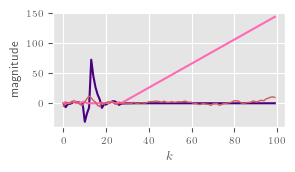

In [ ]:
Klqr_tensor = torch.from_numpy(Klqr)
x = np.ones(T)
P = np.ones(T)
x_true=np.ones(T)

StateReq = deque([])
ActionReq = deque([])

Hyperstate.ChangeInitialStates(torch.atleast_2d(torch.randn(1, 1)), torch.atleast_2d(torch.rand(1, 1)))
true_state = torch.sqrt(Hyperstate.Covariance) * torch.randn(1, 1) + Hyperstate.Mean 

for k in range(T):
    state = torch.cat((Hyperstate.Mean, Hyperstate.Covariance)).T
    action = -Klqr_tensor * (state[0,0]) 
    action = action.clip(-5, 5)
    action = torch.atleast_2d(action.detach())
    true_state_Plus = stateDynamics(true_state, action) + torch.sqrt(Q) * torch.randn(1, 1)
    measurement_Plus_realization = measurementDynamics(true_state_Plus) + torch.sqrt(R) * torch.randn(1, 1)
    StateReq.append(state)
    Hyperstate.ApplyEKF(action, measurement_Plus_realization)
    true_state = true_state_Plus
    x_true[k] = true_state[0,0].detach().numpy()

for i in range(T):
    A = StateReq[i].detach().numpy()
    x[i] = A[0,0]
    P[i] = A[0,1]

plt.style.use('ggplot')
fig= plt.figure(figsize=(FigDim1,FigDim2))
plt.rc('xtick', labelsize=7) #fontsize of the x tick labels
plt.rc('ytick', labelsize=7) #fontsize of the y tick labels
plt.xlabel('$k$', fontsize=9)  
#plt.ylabel('$k$', fontsize=9) 
plt.ylabel('magnitude', fontsize=9) 
plt.rc( 'text', usetex=True )
#plt.ylim([-500, 500])
k=56
plt.plot(range(T), x, color=list(colors.cnames)[k+4])
plt.plot(range(T), P, color=list(colors.cnames)[k+2])
plt.plot(range(T), x_true, linewidth = 1,color=list(colors.cnames)[k+3])
#if saveFigs==True:
 #   plt.savefig('Figures/Example1_LQR.pdf',bbox_inches ="tight")


In [ ]:

import pickle

with open('StateFeedbackGainFunction.pkl', 'wb') as outp:
    pickle.dump(K, outp, pickle.HIGHEST_PROTOCOL)


with open('StateFeedbackGainFunction.pkl', 'rb') as inp:
    K1 = pickle.load(inp)
    print(K1)

A = torch.tensor([1,1])
print(K1(torch.atleast_2d(A)))

<bound method Actor.forward of Actor(
  (OneFunc): Sequential(
    (0): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=2, out_features=64, bias=True)
    (2): ELU(alpha=1.0)
    (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ELU(alpha=1.0)
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Linear(in_features=64, out_features=1, bias=True)
    (8): Tanh()
  )
)>
tensor([[0.8535]], grad_fn=<MulBackward0>)


In [ ]:
A = agent.actorNet.forward(state)
i = random.sample(range(len(A.T)), k=1)
print(i)

[28]
